In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow import keras
from Bio import SeqIO
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import cooler
import pybedtools
from tqdm import tqdm

/pollard/home/lchumpitaz/anaconda2/envs/py37/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/pollard/home/lchumpitaz/anaconda2/envs/py37/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/pollard/home/lchumpitaz/anaconda2/envs/py37/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/pollard/home/lc

In [2]:
def one_hot(seq):
    seq_array = np.array(list(seq))
    label_encoder = LabelEncoder()
    integer_encoded_seq = label_encoder.fit_transform(seq_array)
    onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
    onehot_encoded_seq = onehot_encoder.fit_transform(integer_encoded_seq.reshape( -1, 1))
    onehot_encoded_seq = onehot_encoded_seq.reshape(onehot_encoded_seq.shape[0],-1,1 )
    onehot_encoded_seq = onehot_encoded_seq.astype('uint8')
    return onehot_encoded_seq

In [3]:
cool_path = '/pollard/home/lchumpitaz/hic-data-analysis-bootcamp/notebooks/data/Rao2014-IMR90-MboI-allreps-filtered.10kb.cool'
fasta_path = '/pollard/data/vertebrate_genomes/human/hg19/hg19/hg19.fa'

In [4]:
c = cooler.Cooler(cool_path)

In [5]:
records = list(SeqIO.parse(fasta_path,"fasta"))

In [6]:
maps = list()
x_train = np.zeros((70000, 2*10**6, 4, 1), dtype = 'uint8')
actual= 0

In [7]:
def get_data( cool, records, win_size = 50, examples = 10000):
    global x_train, maps, actual
    bins = c.bins()[:]
    max_examples = bins.index[-1] - win_size + 1
    exam = np.random.choice(range(max_examples) , examples, replace = False)
    np.random.shuffle(exam)
    for i in tqdm(exam):
        
        curr_bins = bins.iloc[i: i+win_size]
        
        if len(curr_bins[curr_bins['weight'] == curr_bins['weight']]) < win_size:
            continue
        
        sequence = ''
        for chrom in curr_bins['chrom'].unique():
            seq_start = curr_bins[curr_bins.chrom == chrom].iloc[0]['start']
            seq_end = curr_bins[curr_bins.chrom == chrom].iloc[-1]['end']
            for record in records:
                if record.id == chrom:
                    sequence += str(record.seq[seq_start:seq_end]).upper()
                    continue
        
        if 'N' in sequence:
            continue
        x_train[actual] =  one_hot(sequence)
        actual+=1
        bin_start = curr_bins.index[0]
        bin_end = curr_bins.index[-1]+1
        arr = c.matrix(balance = False)[bin_start:bin_end,bin_start:bin_end]
        maps.append(arr)
        
        if actual == len(x_train):
            break
        maps = np.array(maps, dtype='uint8')
  #return x_train, maps
    

In [ ]:
get_data(c, records, win_size = 200, examples = 300000)

 36%|███▌      | 107170/300000 [1:35:15<3:15:14, 16.46it/s] 

In [29]:
#np.save('x_train.npy',x_train) about 200gb of data

In [30]:
#np.save('y_train.npy', maps)

In [301]:
print(actual, 'sequences and hi-c maps available for training')

30698 sequnences and hi-c maps available for training


In [18]:
x_train = x_train[0:actual]

In [33]:
len(x_train)

30698

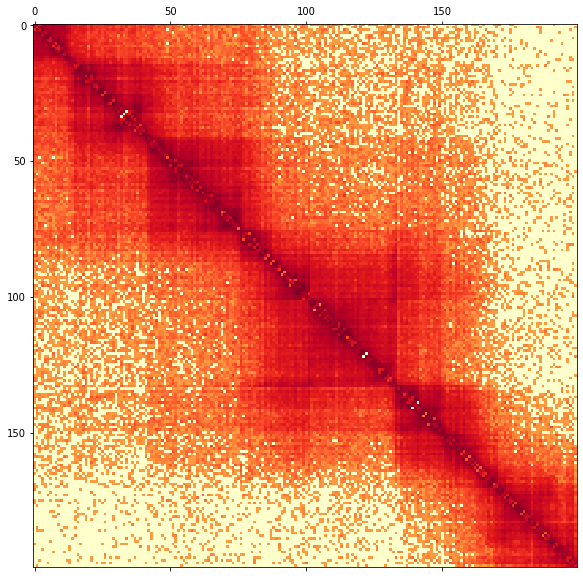

In [122]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
im = ax.matshow(np.log10(maps[0]+0.01), cmap='YlOrRd');

In [34]:
output = maps.reshape(-1, maps.shape[1]*maps.shape[2])
output.shape

(30698, 40000)

In [35]:
input_shape = ( x_train.shape[1], x_train.shape[2], x_train.shape[3])
input_shape

(2000000, 4, 1)

In [323]:
model = keras.models.Sequential()


model.add(keras.layers.Conv2D(32, kernel_size=(20, 4), strides = (1,1), input_shape= input_shape, activation = 'relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(20,1), strides = (20, 1)))
model.add(keras.layers.Conv2D(16, kernel_size=(10, 1), strides = (1,1), activation = 'relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2,1), strides = (2, 1)))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Conv2D(32, kernel_size=(10, 1), strides = (1,1), activation = 'relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2,1), strides = (2, 1)))
model.add(keras.layers.Conv2D(32, kernel_size=(10, 1), strides = (1,1), activation = 'relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2,1), strides = (2, 1)))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Conv2D(8, kernel_size=(10,1), strides = (1,1), activation = 'relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(10,1), strides = (10,1)))
model.add(keras.layers.Conv2D(8, kernel_size=(10,1), strides = (1,1), activation = 'relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(10,1), strides = (10,1)))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Flatten())

#model.add(keras.layers.Dense(200, activation = 'tanh'))
#model.add(keras.layers.Dense(400, activation = 'selu'))

model.add(keras.layers.Dense(200**2, activation = 'relu'))

model.compile(optimizer = 'adam', loss='mse', metrics = ['accuracy'])

In [324]:
model.summary()

Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_161 (Conv2D)          (None, 1999981, 1, 32)    2592      
_________________________________________________________________
max_pooling2d_159 (MaxPoolin (None, 99999, 1, 32)      0         
_________________________________________________________________
conv2d_162 (Conv2D)          (None, 99990, 1, 16)      5136      
_________________________________________________________________
max_pooling2d_160 (MaxPoolin (None, 49995, 1, 16)      0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 49995, 1, 16)      0         
_________________________________________________________________
conv2d_163 (Conv2D)          (None, 49986, 1, 32)      5152      
_________________________________________________________________
max_pooling2d_161 (MaxPoolin (None, 24993, 1, 32)    

In [327]:
xb_train = x_train[0:12]
yb_train = np.log(output[0:12] + 0.01)

In [328]:
model.fit(xb_train, yb_train, epochs = 1, batch_size=4)

12/12 [==============================] - 11s 921ms/sample - loss: 3.7878 - acc: 0.0000e+00


In [329]:
papu = model.predict(x_train[1000:1010])

# Predictions, Really BAD so far

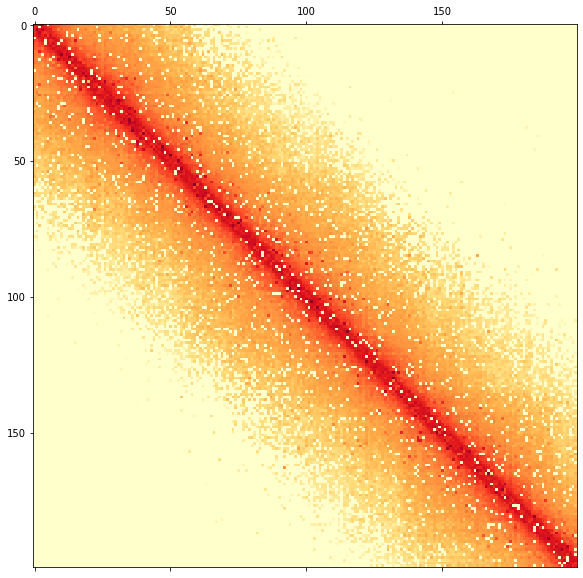

In [330]:
i = 1
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
im = ax.matshow(papu[i].reshape(200, 200), cmap='YlOrRd');

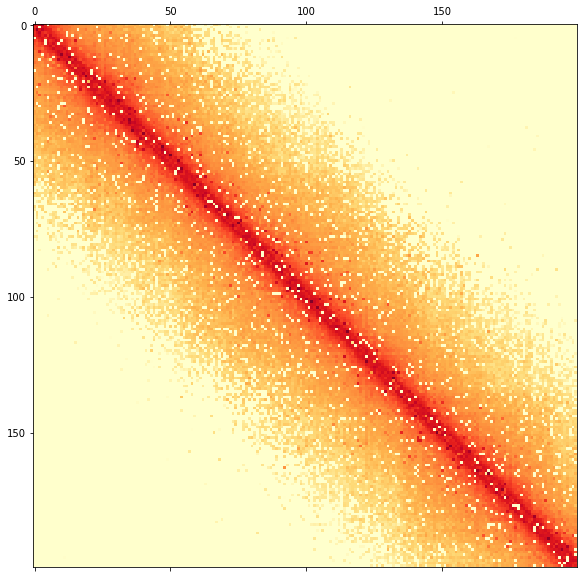

In [331]:
i = 4
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
im = ax.matshow(papu[i].reshape(200, 200), cmap='YlOrRd');